<a href="https://colab.research.google.com/github/hamedebrahimi68/financial_markets_predictoin/blob/master/v4_LSTM_CNN_multifeatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ta

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import ta
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Flatten, concatenate, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime, timedelta
import warnings

warnings.filterwarnings('ignore')

In [4]:
def get_data_from_yahoo(symbol, start_date, end_date, interval='1d'):
    """
    دریافت داده‌های قیمت از یاهو فایننس
    """
    ticker = yf.Ticker(symbol)
    df = ticker.history(start=start_date, end=end_date, interval=interval)
    df.reset_index(inplace=True)
    return df


def prepare_data(dataset):
    """
    آماده‌سازی داده‌ها و اضافه کردن فیچرهای تکنیکال
    """
    # تبدیل تاریخ به تایم‌استمپ
    dataset['timestamp'] = pd.to_datetime(dataset['Date']).astype(np.int64) // 10**9

    # اضافه کردن شاخص‌های تکنیکال
    dataset['RSI'] = ta.momentum.RSIIndicator(dataset['Close']).rsi()
    macd = ta.trend.MACD(dataset['Close'])
    dataset['MACD'] = macd.macd()
    dataset['MACD_signal'] = macd.macd_signal()
    dataset['MACD_diff'] = macd.macd_diff()

    bb = ta.volatility.BollingerBands(dataset['Close'])
    dataset['BB_upper'] = bb.bollinger_hband()
    dataset['BB_middle'] = bb.bollinger_mavg()
    dataset['BB_lower'] = bb.bollinger_lband()
    dataset['BB_width'] = dataset['BB_upper'] - dataset['BB_lower']

    dataset['Volume_MA'] = dataset['Volume'].rolling(window=20).mean()
    dataset['Volume_std'] = dataset['Volume'].rolling(window=20).std()
    dataset['OBV'] = ta.volume.OnBalanceVolumeIndicator(dataset['Close'], dataset['Volume']).on_balance_volume()

    dataset['upper_shadow'] = dataset['High'] - dataset[['Open', 'Close']].max(axis=1)
    dataset['lower_shadow'] = dataset[['Open', 'Close']].min(axis=1) - dataset['Low']
    dataset['body_size'] = abs(dataset['Close'] - dataset['Open'])
    dataset['volatility'] = dataset['Close'].pct_change().rolling(window=20).std()
    dataset['atr'] = ta.volatility.AverageTrueRange(dataset['High'], dataset['Low'], dataset['Close']).average_true_range()
    dataset['price_change'] = dataset['Close'].pct_change()
    dataset['price_change_abs'] = abs(dataset['price_change'])

    dataset = dataset.dropna()

    features = ['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume',
                'RSI', 'MACD', 'MACD_signal', 'MACD_diff',
                'BB_upper', 'BB_middle', 'BB_lower', 'BB_width',
                'Volume_MA', 'Volume_std', 'OBV',
                'upper_shadow', 'lower_shadow', 'body_size',
                'volatility', 'atr', 'price_change', 'price_change_abs']

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(dataset[features])

    return scaled_data, scaler, dataset


def create_sequences(data, seq_length):
    """
    ایجاد سکانس‌های داده برای LSTM
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length][3])  # ستون 3 = Close price
    return np.array(X), np.array(y)


def build_model(seq_length, n_features):
    """ساخت مدل LSTM برای پیش‌بینی قیمت"""
    input_layer = Input(shape=(seq_length, n_features))

    # مسیر CNN
    cnn = Conv1D(filters=32, kernel_size=3, activation='relu')(input_layer)
    cnn = MaxPooling1D(pool_size=2)(cnn)
    cnn = Conv1D(filters=64, kernel_size=3, activation='relu')(cnn)
    cnn = MaxPooling1D(pool_size=2)(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = Flatten()(cnn)

    # مسیر LSTM
    lstm = LSTM(64, return_sequences=True)(input_layer)
    lstm = Dropout(0.1)(lstm)
    lstm = LSTM(32, return_sequences=False)(lstm)
    lstm = Dropout(0.1)(lstm)
    lstm = BatchNormalization()(lstm)

    # ترکیب مسیرها
    combined = concatenate([cnn, lstm])

    # لایه‌های نهایی
    x = Dense(32, activation='relu')(combined)
    x = Dropout(0.2)(x)
    output = Dense(1)(x)  # خروجی یک مقدار پیوسته است (پیش‌بینی قیمت)

    # ایجاد و کامپایل مدل
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])  # استفاده از MSE برای رگرسیون
    return model


def predict_next_period(model, symbol, seq_length=60):
    """
    پیش‌بینی دوره بعدی با استفاده از آخرین داده‌های موجود
    """
    # دریافت داده‌های اخیر
    end_date = datetime.now()
    start_date = end_date - timedelta(days=seq_length * 2)  # دریافت داده‌های بیشتر برای محاسبه شاخص‌ها

    df = get_data_from_yahoo(symbol, start_date, end_date)
    scaled_data, scaler, processed_df = prepare_data(df)

    # آماده‌سازی آخرین سکانس
    last_sequence = scaled_data[-seq_length:]
    last_sequence = np.reshape(last_sequence, (1, seq_length, scaled_data.shape[1]))

    # پیش‌بینی
    prediction = model.predict(last_sequence)
    # تبدیل مقدار پیش‌بینی‌شده به مقیاس اصلی
    predicted_price = scaler.inverse_transform([[0] * 3 + [prediction[0][0]] + [0] * (scaled_data.shape[1] - 4)])[:, 3]
    return predicted_price[0]


def plot_training_history(history):
    """
    رسم نمودار نتایج آموزش
    """
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 177ms/step - loss: 0.4323 - mae: 0.4906 - val_loss: 0.2075 - val_mae: 0.4423
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1005 - mae: 0.2347 - val_loss: 0.2733 - val_mae: 0.5116
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.0197 - mae: 0.1036 - val_loss: 0.2224 - val_mae: 0.4602
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - loss: 0.0103 - mae: 0.0758 - val_loss: 0.1871 - val_mae: 0.4207
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0079 - mae: 0.0649 - val_loss: 0.1642 - val_mae: 0.3934
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.0081 - mae: 0.0652 - val_loss: 0.1442 - val_mae: 0.3682
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.0059 - mae: 0.0571 - val_loss: 0.1295 - val_mae: 0.3478
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.0060 - mae: 0.0575 - val_loss: 0.1039 - val_mae: 0.3106
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.

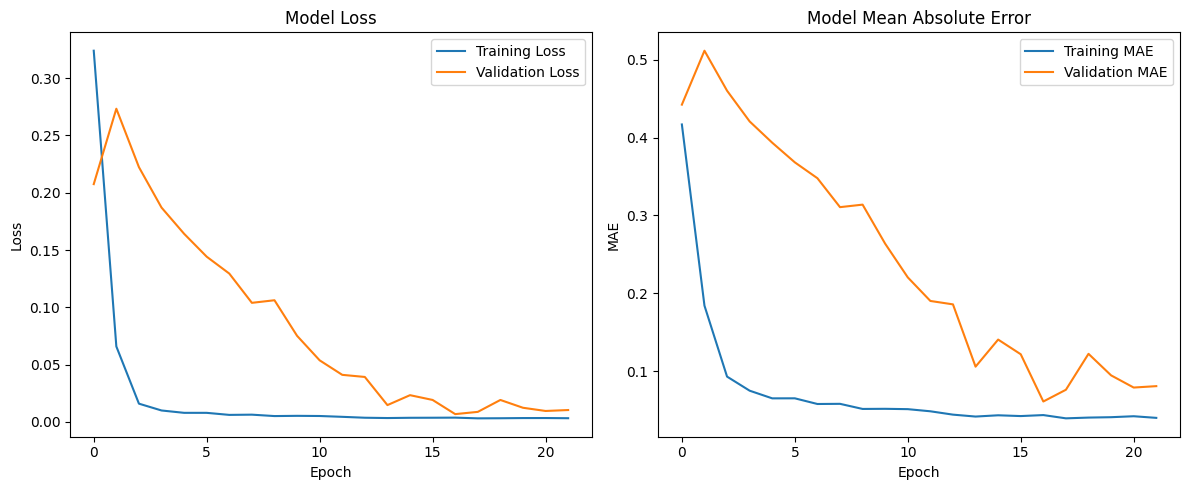

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
پیش‌بینی قیمت دوره بعدی: 107351.18


In [5]:
# تنظیم پارامترها
symbol = "BTC-USD"  # یا هر نماد دیگری
start_date = "2020-01-01"
end_date = datetime.now()
seq_length = 60

# دریافت داده‌ها
df = get_data_from_yahoo(symbol, start_date, end_date)

# آماده‌سازی داده‌ها
scaled_data, scaler, processed_df = prepare_data(df)
X, y = create_sequences(scaled_data, seq_length)

# تقسیم داده‌ها به train و test
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# تنظیم Early Stopping
early_stopping = EarlyStopping(
      monitor='val_loss',
      patience=5,
      restore_best_weights=True
  )

# ساخت و آموزش مدل
model = build_model(seq_length, X.shape[2])
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stopping],
                    verbose=1)

# رسم نمودار نتایج
plot_training_history(history)

# پیش‌بینی دوره بعدی
predicted_price = predict_next_period(model, symbol)
print(f'پیش‌بینی قیمت دوره بعدی: {predicted_price:.2f}')